# Get the Data

In [1]:
import pandas as pd
import os
import tarfile
from six.moves import urllib
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
           os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
fetch_housing_data()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)    
housing = load_housing_data()

# Take a general look at the data

In [3]:
housing.head() # In the following, head shows the first five rows of the data. We cleary see that there are 10 attributes
               # including the label, which is the median house value. 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info() # Info gives an idea about how many examples there are for each attribute
               # We can see that all the attributes have the same number of data except the number of bedrooms.
               # This has to be kept in mind since it needs to be cleaned before the machine learning step. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing.describe() # describe shows many useful descriptions about the data such as the minimum, maximum, median etc...

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


# Create a test and train set

In [12]:
import numpy as np # creating train and test sets from the same distribution is important to train a model then evaluate it 
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [13]:
len(test_set)

4128

In [15]:
# This works, but however, this is not perfect because if we run the program again, the sets will be different. So, 
# your model will see all of your data, which is what you want to avoid. Here another way:
from zlib import crc32
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index() # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
# So far, this is a random splitting. But, if your data is not large enough, you run the risk of sampling bias. 
# Your test set should be representative of your data.
# Suppose that the income is an important attribute. Let's create an income category attribute
housing["income_cat"] = pd.cut(housing["median_income"],
bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
labels=[1, 2, 3, 4, 5])

<AxesSubplot:>

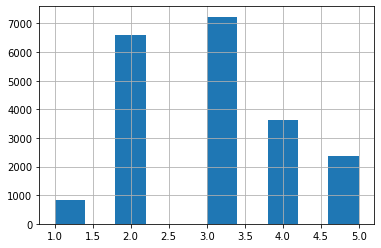

In [25]:
housing["income_cat"].hist()

In [26]:
from sklearn.model_selection import StratifiedShuffleSplit # stratified means that taking data from different categories.
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]): 
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [29]:
strat_test_set.describe() # compare the strat test with usual one 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,4128.000000,4128.000000,4128.000000,4128.000000,4079.000000,4128.000000,4128.000000,4128.000000,4128.000000
mean,-119.545981,35.602049,28.583818,2688.656250,549.721746,1448.634205,509.651163,3.849818,206257.795058
std,2.010400,2.127889,12.629796,2345.997876,454.528621,1197.164964,407.677609,1.879332,114176.653346
min,-124.180000,32.550000,1.000000,2.000000,1.000000,5.000000,1.000000,0.499900,14999.000000
25%,-121.780000,33.920000,18.000000,1474.000000,301.000000,805.750000,283.000000,2.542675,118900.000000
50%,-118.460000,34.220000,28.000000,2159.500000,442.000000,1172.500000,416.000000,3.513200,181300.000000
75%,-117.980000,37.690000,37.000000,3171.250000,653.000000,1754.250000,613.250000,4.739225,268850.000000
max,-114.560000,41.950000,52.000000,32627.000000,6445.000000,28566.000000,6082.000000,15.000100,500001.000000


In [30]:
test_set.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,4128.00000,4128.00000,4128.000000,4128.000000,3921.000000,4128.000000,4128.000000,4128.000000,4128.000000
mean,-119.51936,35.58671,28.764293,2610.796269,535.233104,1421.571705,497.750727,3.830338,205500.309593
std,1.99447,2.13276,12.518304,2209.359101,431.299704,1114.023136,387.770570,1.881515,114486.964288
min,-124.19000,32.54000,1.000000,6.000000,2.000000,8.000000,2.000000,0.499900,14999.000000
25%,-121.69000,33.93000,18.000000,1420.000000,294.000000,781.000000,278.000000,2.548500,119275.000000
50%,-118.47000,34.23000,29.000000,2110.000000,428.000000,1160.000000,406.000000,3.500000,178650.000000
75%,-117.99000,37.70000,37.000000,3099.250000,643.000000,1722.000000,598.000000,4.645925,263000.000000
max,-114.58000,41.81000,52.000000,37937.000000,5471.000000,16122.000000,5189.000000,15.000100,500001.000000


In [31]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Explore the data

In [32]:
# Let's make sure that the test set is aside. Now, we will work with train set. Let's copy it instead of touching it.
housing = strat_train_set.copy()
# So far, we only had a quick understanding of the data. Now, it is time to get a deeper look. 

## Visualize the geographical data

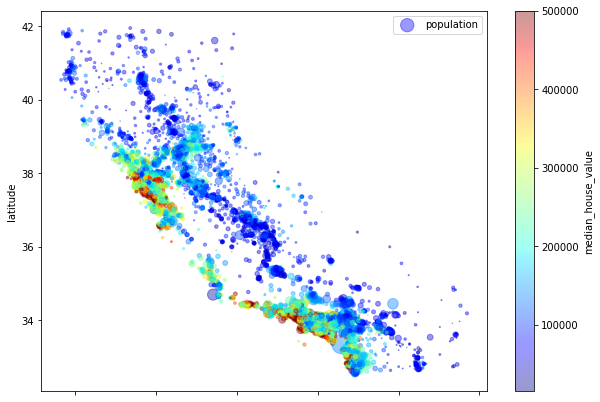

In [34]:
import matplotlib.pyplot as plt
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
s=housing["population"]/100, label="population", figsize=(10,7),
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()
# the graph below shows that the closer to the sea, the more expensive. Moreover, less people, less expensive. 

## Looking for correlations

In [35]:
corr_matrix = housing.corr() # corr() is a function that tells how much the attributes are correlated with the label
corr_matrix["median_house_value"].sort_values(ascending=False) # The higher the correlation, the more the dependence is linear

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

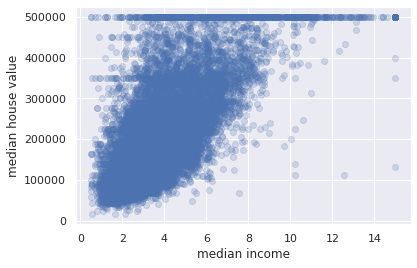

In [37]:
import seaborn as sns
sns.set()
x = housing["median_income"]
y = housing["median_house_value"]
plt.xlabel("median income")
plt.ylabel("median house value")
plt.plot(x,y,'bo',alpha=0.2)
plt.show()


## Attributes combinations

In [38]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN


In [40]:
housing["rooms_per_households"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_rooms"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_households"] = housing["population"]/housing["households"]

In [41]:
corr_matrix = housing.corr() # corr() is a function that tells how much the attributes are correlated with the label
corr_matrix["median_house_value"].sort_values(ascending=False)# As you can see below, the attributes combinations
# helped us to find more correlated attributes than before. For example, the number of bedrooms per rooms attribute 
# is more correlated than the number of bedrooms and the other attributes. 

median_house_value           1.000000
median_income                0.687151
rooms_per_households         0.146255
total_rooms                  0.135140
housing_median_age           0.114146
households                   0.064590
total_bedrooms               0.047781
population_per_households   -0.021991
population                  -0.026882
longitude                   -0.047466
latitude                    -0.142673
bedrooms_per_rooms          -0.259952
Name: median_house_value, dtype: float64

# Prepare the Data for Machine Learning

In [63]:
# First of all, let's drop out the label (median house value)
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN


## Data cleaning

In [43]:
# Most ML algorithms cannot work with missing features. So, we need to fix that. We notice earlier
# that the total bedrooms feature has missing features. There are many ways to solve this issue. Either we get rid of
# the corresponding districts, either we get rid of the whole attribute or we set the missing value to zero, min, max or median.
# Let's set the missing data equal to the median. 
from sklearn.impute import SimpleImputer # sklearn has useful tool (imputer) to take care of that 
imputer = SimpleImputer(strategy="median")
#Let's drop the categorical attribute (ocean_proximity) to calculate the median.
housing_num = housing.drop("ocean_proximity", axis=1)

In [44]:
imputer.fit(housing_num) # imputer calculates the median and saves in an array 

SimpleImputer(strategy='median')

In [45]:
# Let's look at the median values
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [46]:
# If we look at the describe, we should find the same value of the 50%
housing_num.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,534.914639,1419.687379,497.011810,3.875884
std,2.001828,2.137963,12.574819,2138.417080,412.665649,1115.663036,375.696156,1.904931
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566950
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.000000,602.000000,4.745325
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100


In [64]:
# now, let's fill the missing values by the median using imputer.transform
X = imputer.transform(housing_num)
#The result is a plain NumPy array containing the transformed features.
# let's put them again in pandas dataframe
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
#Here we solved this issue, let's look at the data
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.0 MB


## Handling the text and categoric attributes

In [51]:
# Most of machine learning algorithms prefer to work with numerical data. So, let's convert the categorical attribute
# to a numeric one. 
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat) # Here, we converted the categorical attribute to a numerical one.
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [52]:
# However, this does not work correctly, because ML algorithms treat neighboor data as a closer data than the distant value.
# One common solution is to use the Onehot encoding. 
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

## Custom Transformers

In [59]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
        else:
             return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs

array([[-121.46, 38.52, 29.0, ..., 'INLAND', 5.485835694050992,
        3.168555240793201],
       [-117.23, 33.09, 7.0, ..., 'NEAR OCEAN', 6.927083333333333,
        2.6236979166666665],
       [-119.04, 35.37, 44.0, ..., 'INLAND', 5.3933333333333335,
        2.223333333333333],
       ...,
       [-122.72, 38.44, 48.0, ..., '<1H OCEAN', 4.1104651162790695,
        2.6627906976744184],
       [-122.7, 38.31, 14.0, ..., '<1H OCEAN', 6.297405189620759,
        2.411177644710579],
       [-122.14, 39.97, 27.0, ..., 'INLAND', 5.477157360406092,
        3.1725888324873095]], dtype=object)

## Transformations Pipelines 

In [61]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
('imputer', SimpleImputer(strategy="median")),
('attribs_adder', CombinedAttributesAdder()),
('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
("num", num_pipeline, num_attribs),
("cat", OneHotEncoder(), cat_attribs),
])
housing_prepared = full_pipeline.fit_transform(housing)

In [62]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

# Select and train a model

In [65]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
# Done. We have a working linear regression model, let's try it out.

LinearRegression()

In [66]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]


In [67]:
print("Labels:", list(some_labels))

Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [68]:
# Let's compute the mean squared error 
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse
# the result is not satisfying. It is important to wonder why ? Is it because of the data or the model is not powerful enough.#

68627.87390018745

In [69]:
# let's train another model
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [70]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [71]:
# This is surprising! Let's make sure whether this is correct or not 
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)